In [1]:
from trends_core3d import *
import matplotlib.pyplot as plt
from intake import open_catalog
import dask

In [2]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:33992 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 4.00 GB


# Custom part for the ECV evaluator to read in the data 

In [4]:
# Here I use Python Intake for managing the reading of several datasets
cat = open_catalog('/home/crezees/projects/earthdata_reader/catalogs/sm_catalog.yml')

In [40]:
# Read in ERA5 reanalysis monthly means for 2m temperature
mydat = cat['reanalysis_era5_single_levels'](freq='1m',varname='t2m')

# Although this method is called to_dask() it returns a Xarray dataset
mydat = mydat.to_dask()

# Select the month august
mydat = mydat.sel(time=mydat['time.month']==8)

# Reduce data size a little by taking every tenth grid cell in lat and in lon direction
mydat = mydat.t2m[:,::10,::10]

# Since the operations are performed over the time axis, it is important to have only one chunk along the time axis. Other chunk-sizes should be choosen depending on number of cores available
mydat = mydat.chunk({'time': -1, 'latitude' : 37, 'longitude' : 72})

# Print the object to check chunksizes
print(mydat)

<xarray.DataArray 't2m' (time: 40, latitude: 73, longitude: 144)>
dask.array<shape=(40, 73, 144), dtype=float32, chunksize=(40, 37, 72)>
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 1979-08-01 1980-08-01 ... 2018-08-01
Attributes:
    units:      K
    long_name:  2 metre temperature


# Linear trend

In [66]:

''' This framework follows  Weatherhead et al. 1998 [1] for estimating the amount of years needed to detect a trend of certain magnitude with a probability of 90%.

Data is initially resampled to yearly means.

Parameters
----------
trend_name : str
    The name of the trend method used for detrending the data
trend_magnitude : float
    The magnitude of the trend in [data units/decade] in which one would be interested

Returns
-------
    A dictionary containing:
        trend_magnitude : same as above
        std_res : the standard deviation of the residuals
        acf_res : the 1-lag autocorrelation
        n_star : the estimated number of years

References
-----------
[1] Weatherhead, Betsy & C. Reinsel, Gregory & C. Tiao, George & Meng, Xiao-Li & Choi, Dongseok & Cheang, Wai-Kwong & Keller, Teddie & DeLuisi, John & Wuebbles, Donald & Kerr, J & J. Miller, Alvin & Oltmans, Samuel. (1998). Factors affecting the detection of trends: Statistical considerations and applications to environmental data. Journal of Geophysical Research. 1031. 17149-17162. 10.1029/98JD00995. 
'''
   
from statsmodels.tsa.stattools import acf

def weatherhead1d(inputdata,trend_per_year=.1):
    # Calculate according to Weatherhead et al.
    std_res = np.std(inputdata)
    acf_res = acf(inputdata, nlags=1)
    acf_res = acf_res[-1]
    n_star = ((3.3 * std_res / np.abs(trend_per_year)) * (
        (1 + acf_res) / (1 - acf_res))**.5)**(2. / 3.)
    return std_res, acf_res, n_star

a,b,c = dask.array.apply_along_axis(weatherhead1d,0,data_detrended.values,{'trend_per_year' : .2})
#testdat = np.random.random(50)
#testdat[3:5] = np.nan
acf

TypeError: len() of unsized object

In [81]:
testdat = np.random.random((50,50,50))
dask.array.apply_along_axis(acf,0,testdat)

TypeError: len() of unsized object

In [87]:
    import numpy as np
    import dask
    from statsmodels.tsa.stattools import acf

    testdat = np.random.random((10,10))

    # This works fine
    print(acf(testdat[:,0]))

    # This gives an error
    dask.array.apply_along_axis(acf,0,testdat)

    # This works fine again
    dask.array.apply_along_axis(np.std,0,testdat)

[ 1.          0.21944526 -0.16570692 -0.22863521 -0.16377728 -0.16796148
 -0.21467636 -0.02896336  0.1274426   0.12283274]


TypeError: len() of unsized object

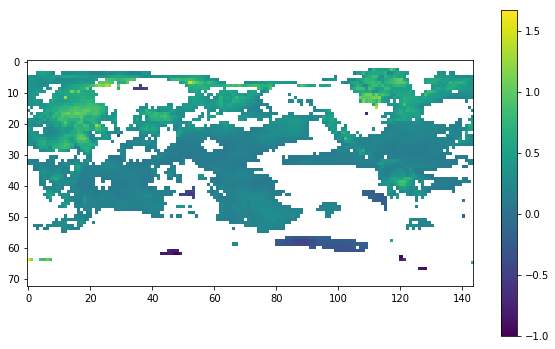

In [43]:
plt.figure(figsize=(10,6))
plt.imshow(10*trend_masked) # Convert to units/decade
plt.colorbar()

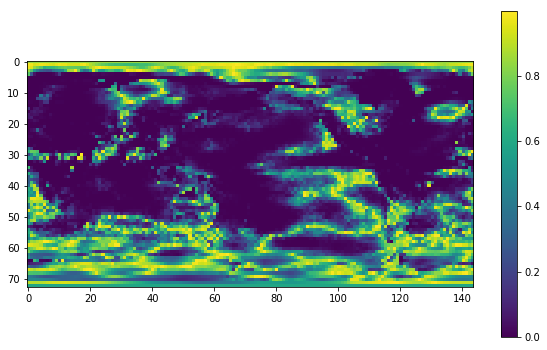

In [31]:
plt.figure(figsize=(10,6))
plt.imshow(pvalue)
plt.colorbar()

In [34]:
trendmasked = result[(pvalue < 0.05)]